## What is the classification performance on balanced dataset?

In [2]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1
    return data, target

In [4]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

In [5]:
# ARMA parameters
seed = 42
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = 23                 # Number of EEG electrodes (channels)
m = 30                   # MA parameter
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
ar = ARMA(window_width=N, order=n_i, memory=m, seed=seed)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [6]:
p_filepath = root + case + preictal_filenames[0]
p_data, _ = load_EEG(p_filepath, 'preictal')
p_data.shape

(23, 230401)

In [7]:
ic_filepath = root + case + interictal_filenames[0]
ic_data, _ = load_EEG(ic_filepath, 'interictal')
ic_data[:,:p_data.shape[1]].shape

(23, 230401)

In [8]:
# load preictal and interictal data
preictal_feature_list = []
interictal_feature_list = []
for i in range(6):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, _ = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    _, _, preictal_features = ar.spin(sig=p_data, fs=256)
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, _ = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    _, _, interictal_features = ar.spin(sig=ic_data[:,:p_data.shape[1]], fs=256)
    
    # store data in list
    preictal_feature_list.append(preictal_features)
    interictal_feature_list.append(interictal_features)

100%|██████████| 229887/229887 [00:01<00:00, 159195.79it/s]


We investigate binary classification of preictal and interictal features using normalised, balanced dataset from EEG channel 1 in case 1. There is 15 mins worth of feature data from both classes in each file.

In [9]:
ch = 0
scaler = StandardScaler() # remove mean, unit variance
preictal_features_scaled = scaler.fit_transform(preictal_feature_list[0][:,ch,:])
interictal_features_scaled = scaler.fit_transform(interictal_feature_list[0][:,ch,:])
print(preictal_features_scaled.shape, interictal_features_scaled.shape)

(449, 2) (449, 2)


In [10]:
transformer = MinMaxScaler() # scales each feature to range [0,1]
preictal_features_scaled = transformer.fit(preictal_feature_list[0][:,ch,:]).transform(preictal_feature_list[0][:,ch,:])
interictal_features_scaled = transformer.fit(interictal_feature_list[0][:,ch,:]).transform(interictal_feature_list[0][:,ch,:])
print(preictal_features_scaled.shape, interictal_features_scaled.shape)

(449, 2) (449, 2)


In [11]:
df = pd.DataFrame(preictal_features_scaled, columns=['Feature 1', 'Feature 2'])
df['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_features_scaled, columns=['Feature 1', 'Feature 2'])
df_2['Interval'] = 'Interictal'
frames = [df, df_2]
rdf = pd.concat(frames)
rdf

,Feature 1,Feature 2,Interval
0,1.000000,0.000000,Preictal
1,1.000000,0.000000,Preictal
2,1.000000,0.000000,Preictal
3,1.000000,0.000000,Preictal
4,1.000000,0.000000,Preictal
...,...,...,...
444,0.670412,0.601113,Interictal
445,0.754295,0.608465,Interictal
446,0.318753,0.844490,Interictal
447,0.504616,0.730617,Interictal


In [12]:
rdf["Interval"].value_counts()

Preictal      449
Interictal    449
Name: Interval, dtype: int64

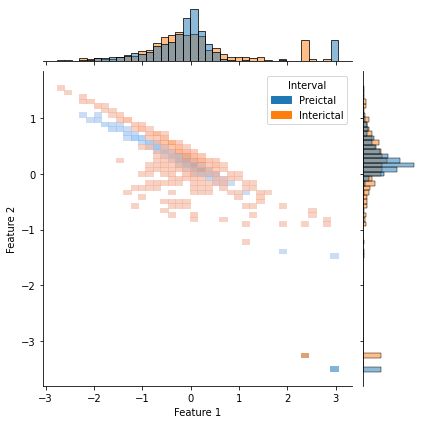

In [165]:
# visualise distribution
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='hist', alpha=0.6)
plt.show()

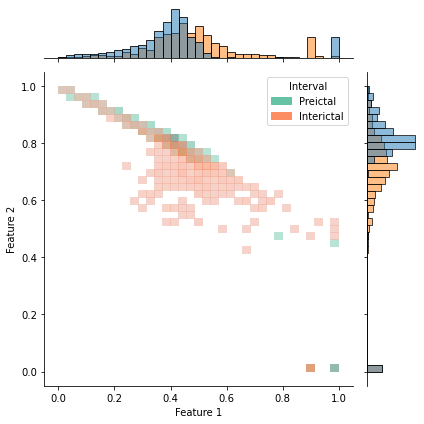

In [15]:
# visualise distribution
palette = sns.color_palette('Set2', n_colors=2)
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='hist', palette=palette, alpha=0.6)
plt.tight_layout()
plt.savefig('../figures/classification/chb01/AR_scaling.pdf')
plt.show()

In [16]:
X = np.concatenate((interictal_features_scaled, preictal_features_scaled))

interictal_targets = -1 * np.ones(interictal_features_scaled.shape[0])
preictal_targets = np.ones(preictal_features_scaled.shape[0])
y = np.hstack((interictal_targets, preictal_targets))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

[[30 15]
 [ 2 43]]
              precision    recall  f1-score   support

        -1.0       0.94      0.67      0.78        45
         1.0       0.74      0.96      0.83        45

    accuracy                           0.81        90
   macro avg       0.84      0.81      0.81        90
weighted avg       0.84      0.81      0.81        90



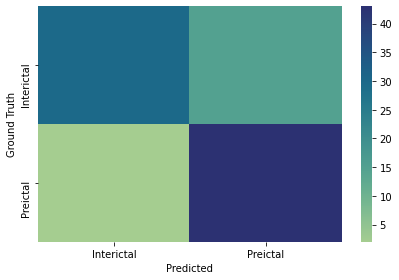

In [21]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()
plt.savefig('../figures/classification/chb01/AR_scaled_SVM_heatmap.pdf')
plt.show()

[[76 18]
 [ 0 86]]
              precision    recall  f1-score   support

        -1.0       1.00      0.81      0.89        94
         1.0       0.83      1.00      0.91        86

    accuracy                           0.90       180
   macro avg       0.91      0.90      0.90       180
weighted avg       0.92      0.90      0.90       180



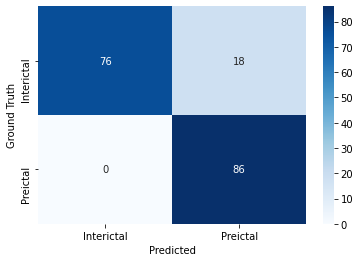

In [131]:
svc = SVC(kernel='rbf', C=11, gamma=7)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[29 65]
 [ 1 85]]
              precision    recall  f1-score   support

        -1.0       0.97      0.31      0.47        94
         1.0       0.57      0.99      0.72        86

    accuracy                           0.63       180
   macro avg       0.77      0.65      0.59       180
weighted avg       0.78      0.63      0.59       180



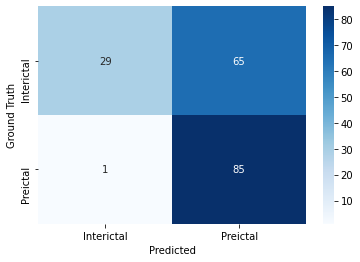

In [109]:
svc = SVC(kernel='poly', degree=2)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[34 60]
 [53 33]]
              precision    recall  f1-score   support

        -1.0       0.39      0.36      0.38        94
         1.0       0.35      0.38      0.37        86

    accuracy                           0.37       180
   macro avg       0.37      0.37      0.37       180
weighted avg       0.37      0.37      0.37       180



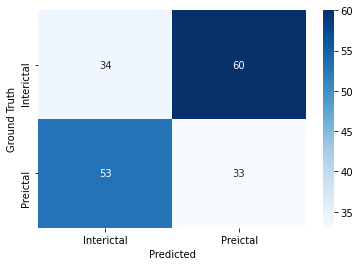

In [110]:
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[12 82]
 [ 1 85]]
              precision    recall  f1-score   support

        -1.0       0.92      0.13      0.22        94
         1.0       0.51      0.99      0.67        86

    accuracy                           0.54       180
   macro avg       0.72      0.56      0.45       180
weighted avg       0.73      0.54      0.44       180



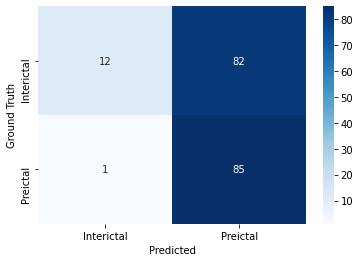

In [111]:
logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()